# 8강. 도로 영역을 찾자! - 세그멘테이션 모델 만들기

## 8-2. 시맨틱 세그멘테이션 데이터셋
### 이미지, 데이터 가져오기
- [데이터](https://www.cvlibs.net/datasets/kitti/eval_semantics.php) : 지금까지의 라벨 데이터와 다르게 세그멘테이션 데이터는 이미지 형태의 라벨로 되어있다.  
- [이미지 라벨정보](https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py) -> 도로 label은 7

In [1]:
#!mkdir -p ~/aiffel/semantic_segmentation/data
#!ln -s  ~/data/* ~/aiffel/semantic_segmentation/data/

### 데이터 로더(data loader) 만들기
- 로더는 입력값 (224, 224), 출력값 (224, 244) 크기를 갖는 모델을 학습시킬 수 있도록 데이터셋을 파싱 해야한다.
- 데이터 로더에 augmentation을 적용한다. -> albumentations을 사용. (Augmentation의 경우 imgaug 등 다른 라이브러리도 활용 가능)
- 학습셋의 일정량을 검증 데이터셋(validation dataset)으로 분리한다.
- 데이터 로더를 만든 후에는 데이터셋이 잘 파싱 되어 나오는지 꼭 확인한다. 데이터셋에 오류가 없어야 성능이 안 나오더라도 문제를 찾기 쉽다.
 - [코드 구현 참고 1_Keras Sequence에 기반한 Dataloader](https://hwiyong.tistory.com/241)
 - [코드 구현 참고 2_Albumentation을 적용한 Keras sequence](https://medium.com/the-artificial-impostor/custom-image-augmentation-with-keras-70595b01aeac)

In [2]:
#!pip list | grep albumentations

In [3]:
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

In [6]:
# Augmentation, Resize
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
  if is_train:    # 훈련용 데이터
    return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
  return Compose([      # 테스트용 데이터
                Resize(                # 입력이미지를 224X224로 resize
                    width=224,
                    height=224
                    )
                ])

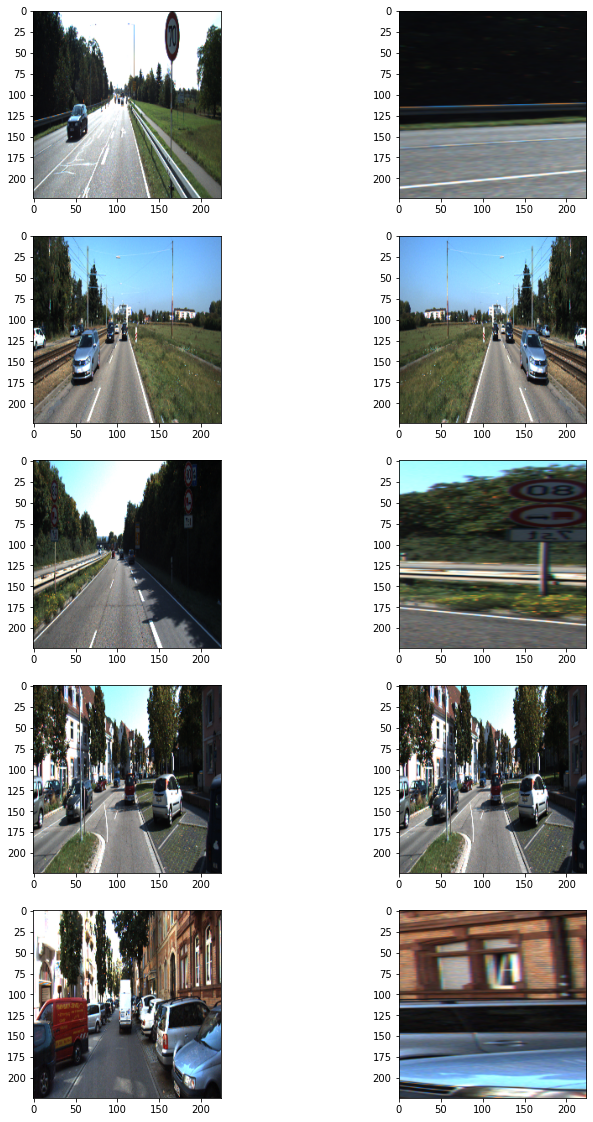

In [7]:
# 이미지 불러오기
dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

augmentation_train = build_augmentation()
augmentation_test = build_augmentation(is_train=False)
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋 5개에 augmentation 적용해보기
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation_test(**image_data)
    processed = augmentation_train(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
  
plt.show()

In [8]:
# 데이터셋 구성하기(tf.keras.utils.Sequence를 상속받은 generator 형태)
class KittiGenerator(tf.keras.utils.Sequence):
  '''
  KittiGenerator는 tf.keras.utils.Sequence를 상속받는다.
  KittiDataset을 원하는 방식으로 preprocess하기 위해 Sequnce를 커스텀해 사용한다.
  '''
  def __init__(self, 
               dir_path,
               batch_size=16,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):
    '''
    dir_path: dataset의 directory path
    batch_size: batch_size
    img_size: preprocess에 사용할 입력이미지의 크기
    output_size: ground_truth를 만들어주기 위한 크기
    is_train: Generator가 학습용인지 테스트용인지 구분
    augmentation: 적용하길 원하는 augmentation 함수를 인자로 받기
    '''
    self.dir_path = dir_path
    self.batch_size = batch_size
    self.is_train = is_train
    self.dir_path = dir_path
    self.augmentation = augmentation
    self.img_size = img_size
    self.output_size = output_size

    # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지 확인
    self.data = self.load_dataset()

  def load_dataset(self):
    # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수
    # is_train에 따라 test set을 분리해서 load 해야한다.
    input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
    label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
    input_images.sort()
    label_images.sort()
    assert len(input_images) == len(label_images)
    data = [ _ for _ in zip(input_images, label_images)]

    if self.is_train:
      return data[:-30]
    return data[-30:]
    
  def __len__(self):
    # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환
    return math.ceil(len(self.data) / self.batch_size)

  def __getitem__(self, index):
    # 입력과 출력 만들기
    # 입력은 resize및 augmentation이 적용된 input image
    # 출력은 semantic label
    batch_data = self.data[
                           index*self.batch_size:
                           (index + 1)*self.batch_size
                           ]
    inputs = np.zeros([self.batch_size, *self.img_size])
    outputs = np.zeros([self.batch_size, *self.output_size])
        
    for i, data in enumerate(batch_data):
      input_img_path, output_path = data
      _input = imread(input_img_path)
      _output = imread(output_path)
      _output = (_output==7).astype(np.uint8)*1
      data = {
          "image": _input,
          "mask": _output,
          }
      augmented = self.augmentation(**data)
      inputs[i] = augmented["image"]/255
      outputs[i] = augmented["mask"]
      return inputs, outputs

  def on_epoch_end(self):
    # 한 epoch가 끝나면 실행되는 함수. 학습중인 경우에 순서를 random shuffle하도록 적용.
    self.indexes = np.arange(len(self.data))
    if self.is_train == True :
      np.random.shuffle(self.indexes)
      return self.indexes

In [9]:
# 위의 함수들 적용하기
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

## 8-3. 시맨틱 세그멘테이션 모델
### 모델 구조 만들기
![Unet 구조](https://user-images.githubusercontent.com/116326867/215251103-6e0f473c-68ba-455e-bea3-fa91a16ece4a.png)

In [10]:
def build_model(input_shape=(224, 224, 3)):
  inputs = Input(input_shape)

  #Contracting Path
  conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
  conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1)
  conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2)
  conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3)
  conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4)
  drop4 = Dropout(0.5)(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
  
  conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
  conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv5)
  
  #Expanding Path
  drop5 = Dropout(0.5)(conv5)
  up6 = Conv2DTranspose(512, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(drop5)
  merge6 = concatenate([drop4,up6], axis = 3)
  conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge6)
  conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv6)
  up7 = Conv2DTranspose(256, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv6)
  merge7 = concatenate([conv3,up7], axis = 3)
  conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge7)
  conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv7)
  up8 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv7)
  merge8 = concatenate([conv2,up8], axis = 3)
  conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge8)
  conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv8)
  up9 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv8)
  merge9 = concatenate([conv1,up9], axis = 3)
  conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge9)
  conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)  
  conv9 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)     
  conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

  model = Model(inputs = inputs, outputs = conv10)
  return model

- 패딩을 적용하였으나, 적용하지 않아도 무방.

### 모델 학습하기

In [11]:
model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet.h5'

model = build_model()
model.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy')
model.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

model.save(model_path)  #학습한 모델 저장하기

Epoch 1/100
11/11 [==============================] - 23s 640ms/step - loss: 0.6795 - val_loss: 0.6551
Epoch 2/100
11/11 [==============================] - 7s 610ms/step - loss: 0.5433 - val_loss: 0.1297
Epoch 3/100
11/11 [==============================] - 7s 596ms/step - loss: 0.0328 - val_loss: 0.0268
Epoch 4/100
11/11 [==============================] - 7s 594ms/step - loss: 0.0361 - val_loss: 0.0307
Epoch 5/100
11/11 [==============================] - 7s 595ms/step - loss: 0.0398 - val_loss: 0.0298
Epoch 6/100
11/11 [==============================] - 7s 603ms/step - loss: 0.0310 - val_loss: 0.0285
Epoch 7/100
11/11 [==============================] - 7s 608ms/step - loss: 0.0365 - val_loss: 0.0344
Epoch 8/100
11/11 [==============================] - 7s 610ms/step - loss: 0.0424 - val_loss: 0.0335
Epoch 9/100
11/11 [==============================] - 7s 620ms/step - loss: 0.0360 - val_loss: 0.0348
Epoch 10/100
11/11 [==============================] - 7s 626ms/step - loss: 0.0368 - val_l

## 8-4. 시맨틱 세그멘테이션 모델 시각화

In [12]:
# 미리 준비한 모델을 불러오기
#model_path = dir_path + '/seg_model_unet.h5' 

# 위에서 학습한 모델 불러오기
model = tf.keras.models.load_model(model_path)

In [13]:
# image_path로 입력된 이미지를 입력받아 preprocess를 해서 model로 infernece한 결과를 시각화하고 이를 output_path에 저장하는 함수
def get_output(model, preproc, image_path, output_path):
     origin_img = imread(image_path)
     data = {"image":origin_img}
     processed = preproc(**data)
     output = model(np.expand_dims(processed["image"]/255,axis=0))
     output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라진다.
     output = Image.fromarray(output)
     background = Image.fromarray(origin_img).convert('RGBA')
     output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
     output = Image.blend(background, output, alpha=0.5)
     output.show()
     return output 

- 테스트 셋은 이미지를 제공하지만 정답 데이터를 제공하지 않으므로 모델이 추론(inference)한 결과를 눈으로 확인할 수 있는 세그멘테이션 이미지로 만들어야한다. 이때 입력 이미지와 라벨을 한 번에 볼 수 있도록 모델의 출력값을 입력 이미지 위에 겹쳐서 보이기, 즉 오버레이(overray)하는데, PIL 패키지의 Image.blend를 활용한다.

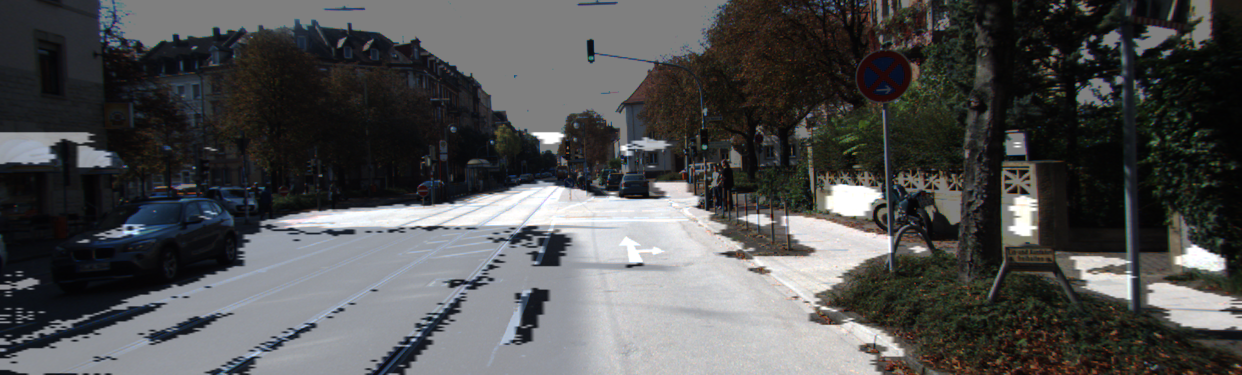

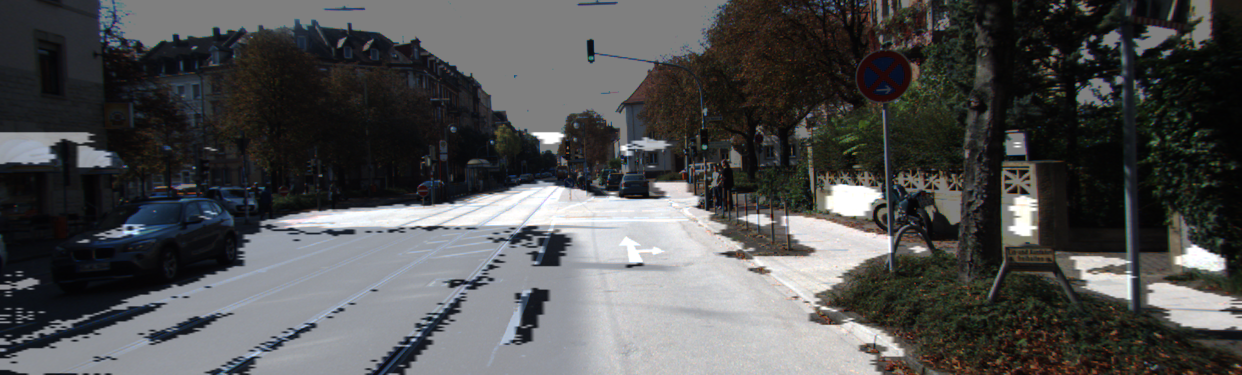

In [14]:
# 시각화
i = 1    # i값을 바꾸면 테스트용 파일이 달라진다. 
get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

In [15]:
# IoU 계산
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

In [16]:
# get_output 확장
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라진다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

- 세그멘테이션이 성능을 정량적으로 측정하기 위한 방법으로 IoU(Intersection over Union)를 계산하기 위해 함수를 구현한다.
- 함수 구현하기 : IoU를 계산하려면 모델이 도로 영역이라고 판단한 부분이 1로, 나머지 부분이 0으로 표시된 행렬, 그리고 라벨 데이터에서 도로 영역이 1, 나머지 부분이 0으로 표시된 행렬이 필요하다. 각각을 prediction, target이라고 부른다. 위에 구현했던 get_output을 좀 더 확장해서 output, prediction, target을 함께 리턴하도록 구현한다.

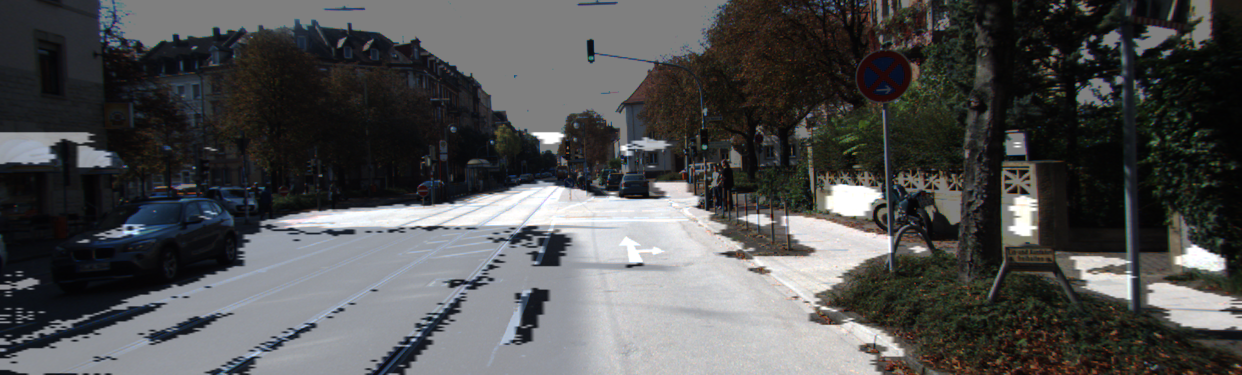

IoU : 0.724235


0.7242345407244346

In [17]:
# 시각화
i = 1    # i값을 바꾸면 테스트용 파일이 달라진다. 
output, prediction, target = get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)